In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

def parser2(x):
	return datetime.strptime(x, '%Y-%m-%d')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #model = Sequential()
    #model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    #model.add(Dense(1))

    model = Sequential()    
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(0.2))
    # setting return_sequences=True will allow access to the hidden state output for each input time step
    model.add(LSTM(12, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(24, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(36, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(24, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(12, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))        
    # this is the last LSTM, no need to pass hidden state output
    # so should use return_sequences=False
    model.add(LSTM(8, activation='relu', return_sequences=False)) 
    #model.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))


    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
#file = 'shampoo-sales.csv'
#file = 'SortedInts4.csv'
#series = read_csv(file, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

file = 'AAPLshort.csv'
series = read_csv(file, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser2)

series

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
Using TensorFlow backend.


date
2019-10-04    227.01
2019-10-07    227.06
2019-10-08    224.40
2019-10-09    227.03
2019-10-10    230.09
               ...  
2020-06-15    342.99
2020-06-16    352.08
2020-06-17    351.59
2020-06-18    351.73
2020-06-19    349.72
Name: 0, Length: 179, dtype: float64

In [2]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#Train = train_scaled
#Test = train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)

In [3]:
#train_reshaped

In [4]:
# fit the model
# very good at modelling data like this 1,2,3,4,5...
# very good at 1,2,1,2,... also
# very good at sqrt(1), sqrt(2), ...
# ok at 1,2,3,4,5,4,3,2... took a few days to start to match
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting

lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=326.188269, Expected=322.320000
Month=2, Predicted=323.388269, Expected=331.500000
Month=3, Predicted=332.568269, Expected=333.460000
Month=4, Predicted=334.528269, Expected=343.990000
Month=5, Predicted=340.980001, Expected=352.840000
Month=6, Predicted=349.830000, Expected=335.900000
Month=7, Predicted=336.968269, Expected=338.800000
Month=8, Predicted=339.868269, Expected=342.990000
Month=9, Predicted=344.058269, Expected=352.080000
Month=10, Predicted=352.588333, Expected=351.590000
Month=11, Predicted=352.658269, Expected=351.730000
Month=12, Predicted=352.798269, Expected=349.720000


Test RMSE: 7.039


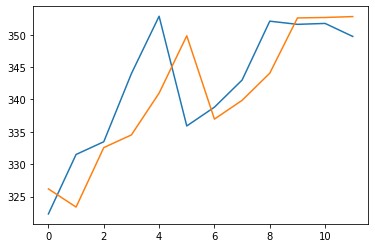

In [5]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:]+.01) # adding the .01 to make both lines visible
pyplot.plot(predictions)
pyplot.show()

In [6]:
raw_values[-12:]

array([322.32, 331.5 , 333.46, 343.99, 352.84, 335.9 , 338.8 , 342.99,
       352.08, 351.59, 351.73, 349.72])

In [7]:
print('finished')

finished
